In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
import gdown

warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

train_id = "1oLZ8ThjyPW6DQLswbkH39NwThzBCzql6"
test_id = "1fCMpT5c7evhyiqSDUroBQJrgWIMga5tH"
gender_id = "1NXuoZZzzzO7q2iFB90RUTjrHfSngV6g-"

gdown.download(f"https://drive.google.com/uc?id={train_id}", "train.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={test_id}", "test.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={gender_id}", "gender_submission.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1oLZ8ThjyPW6DQLswbkH39NwThzBCzql6
To: /content/train.csv
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 61.2k/61.2k [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fCMpT5c7evhyiqSDUroBQJrgWIMga5tH
To: /content/test.csv
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 28.6k/28.6k [00:00<00:00, 36.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NXuoZZzzzO7q2iFB90RUTjrHfSngV6g-
To: /content/gender_submission.csv
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 3.26k/3.26k [00:00<00:00, 4.53MB/s]


'gender_submission.csv'


LOAD DATASET
Rows: 891 | Columns: 12


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S


SCHEMA & DATA TYPES
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

MISSING VALUES OVERVIEW


Missing  Missing_%
Cabin         687      77.10
Age           177      19.87
Embarked        2       0.22


DESCRIPTIVE STATISTICS (NUMERIC)


count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292


TARGET (SURVIVED) DISTRIBUTION
Survival rate: 38.38%  (0 = Died, 1 = Survived)


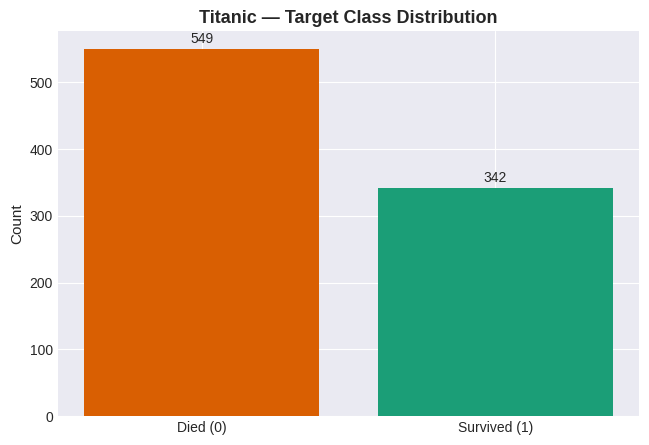


SURVIVAL RATE BY SEX


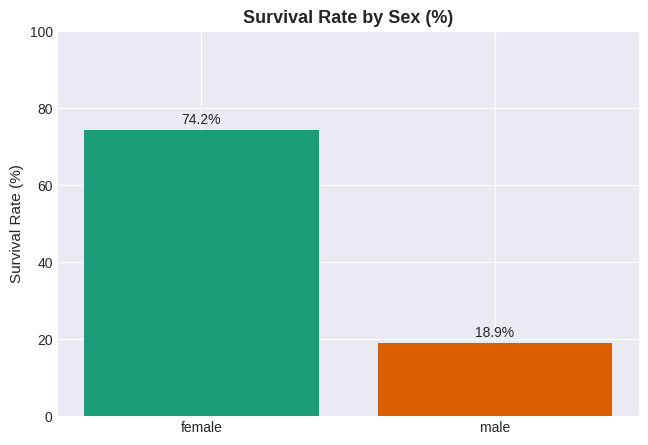


SURVIVAL RATE BY TICKET CLASS (PCLASS)


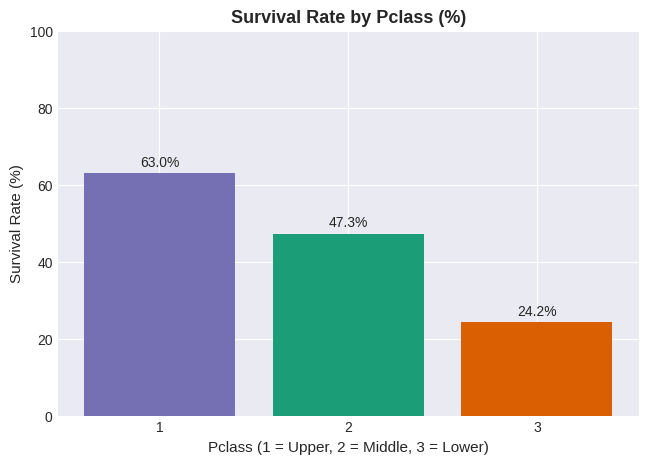


STEP 01 COMPLETE
Dataset loaded, inspected, and key target patterns visualized.


In [24]:
# ============================
# STEP 01 â€” DATA INTAKE & SANITY CHECKS
# ============================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import gdown


def section(title):
    print("\n" + "="*90)
    print(f"{title}".upper())
    print("="*90)

plt.rcParams.update({
    "figure.figsize": (7.5, 5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})
PALETTE = {
    "primary":  "#1b9e77",
    "accent":   "#d95f02",
    "neutral":  "#7570b3",
    "muted":    "#e7298a"
}

TRAIN_ID  = "1oLZ8ThjyPW6DQLswbkH39NwThzBCzql6"
TEST_ID   = "1fCMpT5c7evhyiqSDUroBQJrgWIMga5tH"
GENDER_ID = "1NXuoZZzzzO7q2iFB90RUTjrHfSngV6g-"

if not os.path.exists("train.csv"):
    gdown.download(f"https://drive.google.com/uc?id={TRAIN_ID}", "train.csv", quiet=False)
if not os.path.exists("test.csv"):
    gdown.download(f"https://drive.google.com/uc?id={TEST_ID}", "test.csv", quiet=False)
if not os.path.exists("gender_submission.csv"):
    gdown.download(f"https://drive.google.com/uc?id={GENDER_ID}", "gender_submission.csv", quiet=False)

section("Load Dataset")
df = pd.read_csv("train.csv")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")
display(df.head(3))

section("Schema & Data Types")
print(df.dtypes)

section("Missing Values Overview")
missing = df.isna().sum().rename("Missing")
missing_pct = ((df.isna().sum()/len(df))*100).round(2).rename("Missing_%")
mv = pd.concat([missing, missing_pct], axis=1)
display(mv[mv["Missing"] > 0].sort_values("Missing", ascending=False))

section("Descriptive Statistics (Numeric)")
display(df.describe().T)

section("Target (Survived) Distribution")
surv_counts = df["Survived"].value_counts().sort_index()
surv_rate = df["Survived"].mean()
print(f"Survival rate: {surv_rate:.2%}  (0 = Died, 1 = Survived)")

fig = plt.figure()
values = surv_counts.values
labels = ["Died (0)", "Survived (1)"]
bars = plt.bar(labels, values, color=[PALETTE["accent"], PALETTE["primary"]])
plt.title("Titanic â€” Target Class Distribution")
plt.ylabel("Count")
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, height + 5, f"{int(height)}", ha="center", va="bottom", fontsize=10)
plt.show()

section("Survival Rate by Sex")
if {"Sex","Survived"}.issubset(df.columns):
    sex_rate = df.groupby("Sex")["Survived"].mean().sort_values(ascending=False)
    fig = plt.figure()
    bars = plt.bar(sex_rate.index.astype(str), (sex_rate.values*100), color=[PALETTE["primary"], PALETTE["accent"]])
    plt.title("Survival Rate by Sex (%)")
    plt.ylabel("Survival Rate (%)")
    for i, b in enumerate(bars):
        plt.text(b.get_x() + b.get_width()/2, b.get_height()+1, f"{sex_rate.values[i]*100:.1f}%",
                 ha="center", va="bottom", fontsize=10)
    plt.ylim(0, 100)
    plt.show()
else:
    print("Columns required not found: Sex, Survived")

section("Survival Rate by Ticket Class (Pclass)")
if {"Pclass","Survived"}.issubset(df.columns):
    pclass_rate = df.groupby("Pclass")["Survived"].mean().sort_index()
    fig = plt.figure()
    bars = plt.bar(pclass_rate.index.astype(str), (pclass_rate.values*100), color=[PALETTE["neutral"], PALETTE["primary"], PALETTE["accent"]])
    plt.title("Survival Rate by Pclass (%)")
    plt.xlabel("Pclass (1 = Upper, 2 = Middle, 3 = Lower)")
    plt.ylabel("Survival Rate (%)")
    for i, b in enumerate(bars):
        plt.text(b.get_x() + b.get_width()/2, b.get_height()+1, f"{pclass_rate.values[i]*100:.1f}%",
                 ha="center", va="bottom", fontsize=10)
    plt.ylim(0, 100)
    plt.show()
else:
    print("Columns required not found: Pclass, Survived")

section("Step 01 Complete")
print("Dataset loaded, inspected, and key target patterns visualized.")


 Loading Titanic Dataset...

 Training Set:  891 rows, 12 columns
 Test Set:      418 rows, 11 columns

 First 5 rows of Training Data:


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S


ðŸ“‘ Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


 Summary Statistics:


count unique                  top freq       mean         std  \
PassengerId  891.0    NaN                  NaN  NaN      446.0  257.353842   
Survived     891.0    NaN                  NaN  NaN   0.383838    0.486592   
Pclass       891.0    NaN                  NaN  NaN   2.308642    0.836071   
Name           891    891  Dooley, Mr. Patrick    1        NaN         NaN   
Sex            891      2                 male  577        NaN         NaN   
Age          714.0    NaN                  NaN  NaN  29.699118   14.526497   
SibSp        891.0    NaN                  NaN  NaN   0.523008    1.102743   
Parch        891.0    NaN                  NaN  NaN   0.381594    0.806057   
Ticket         891    681               347082    7        NaN         NaN   
Fare         891.0    NaN                  NaN  NaN  32.204208   49.693429   
Cabin          204    147                   G6    4        NaN         NaN   
Embarked       889      3                    S  644        NaN         NaN   

              min     25%      50%    75%       max  
PassengerId   1.0   223.5    446.0  668.5     891.0  
Survived      0.0     0.0      0.0    1.0       1.0  
Pclass        1.0     2.0      3.0    3.0       3.0  
Name          NaN     NaN      NaN    NaN       NaN  
Sex           NaN     NaN      NaN    NaN       NaN  
Age          0.42  20.125     28.0   38.0      80.0  
SibSp         0.0     0.0      0.0    1.0       8.0  
Parch         0.0     0.0      0.0    0.0       6.0  
Ticket        NaN     NaN      NaN    NaN       NaN  
Fare          0.0  7.9104  14.4542   31.0  512.3292  
Cabin         NaN     NaN      NaN    NaN       NaN  
Embarked      NaN     NaN      NaN    NaN       NaN

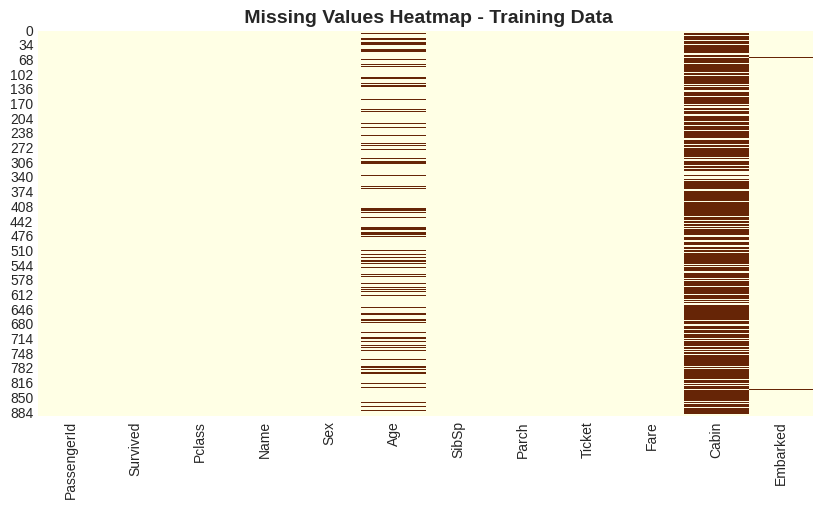


 Columns with Missing Values:


Cabin       687
Age         177
Embarked      2
dtype: int64

In [25]:
# ================================
# STEP 02: Load & Inspect Dataset
# ================================

print(" Loading Titanic Dataset...")

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_df = pd.read_csv("gender_submission.csv")

print("\n Training Set: ", train_df.shape[0], "rows,", train_df.shape[1], "columns")
print(" Test Set:     ", test_df.shape[0], "rows,", test_df.shape[1], "columns")

print("\n First 5 rows of Training Data:")
display(train_df.head())

print("\nðŸ“‘ Data Info:")
display(train_df.info())

print("\n Summary Statistics:")
display(train_df.describe(include="all").T)

plt.figure(figsize=(10, 5))
sns.heatmap(train_df.isnull(), cbar=False, cmap="YlOrBr")
plt.title(" Missing Values Heatmap - Training Data", fontsize=14, weight='bold')
plt.show()

missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if not missing_values.empty:
    print("\n Columns with Missing Values:")
    display(missing_values)
else:
    print("\n No Missing Values Found!")


In [26]:
# Step 02.1: Feature Overview (Categorical vs Numerical)

target_col = "Survived"

numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols.remove("PassengerId")
numerical_cols.remove(target_col)

categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

print(" Target Column:", target_col, "\n")
print(" Numerical Features:", numerical_cols, "\n")
print(" Categorical Features:", categorical_cols, "\n")

feature_summary = []

for col in train_df.columns:
    if col == target_col:
        col_type = "Target"
    elif col in numerical_cols:
        col_type = "Numerical"
    elif col in categorical_cols:
        col_type = "Categorical"
    elif col == "PassengerId":
        col_type = "Identifier"
    else:
        col_type = "Other"

    feature_summary.append({
        "Feature": col,
        "Type": col_type,
        "Missing Values": train_df[col].isna().sum(),
        "Unique Values": train_df[col].nunique(),
        "Example": train_df[col].dropna().iloc[0]
    })

feature_summary_df = pd.DataFrame(feature_summary)

print("\n Feature Summary Table:\n")
from IPython.display import display
display(feature_summary_df.style.background_gradient(cmap="Blues").set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('background-color', '#1f77b4'), ('color','white')]}]
).set_properties(**{'text-align': 'center'}))

section("Step 02 Complete")

 Target Column: Survived 

 Numerical Features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] 

 Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 


 Feature Summary Table:




STEP 02 COMPLETE



DATASET RECAP
Train shape: (891, 12);  Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

TARGET DISTRIBUTION â€” SURVIVED (0/1)


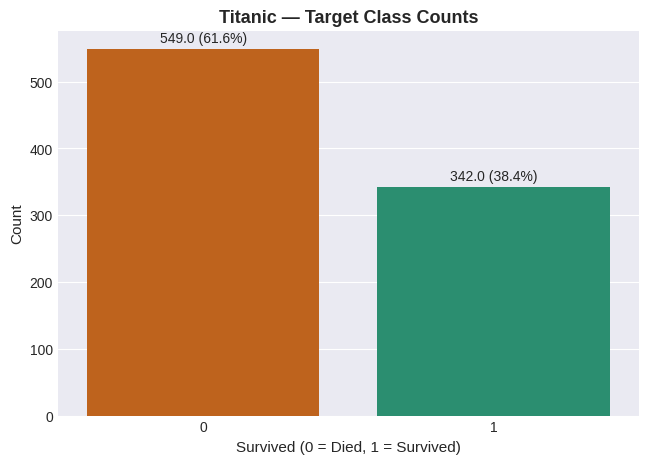


CATEGORICAL FEATURES â€” COUNTS


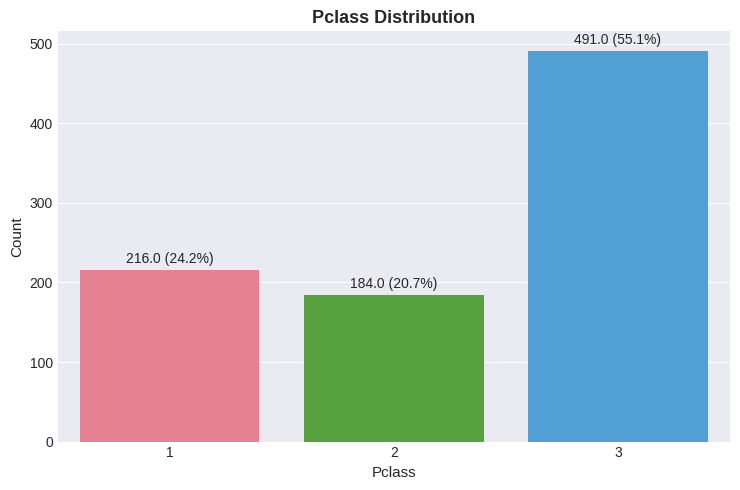

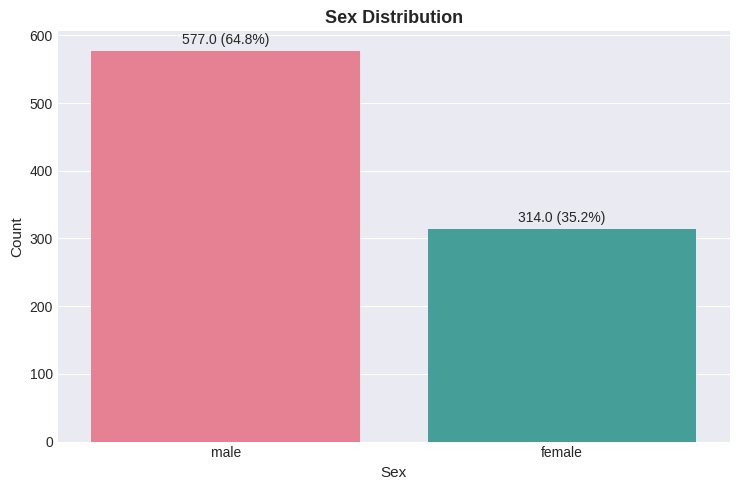

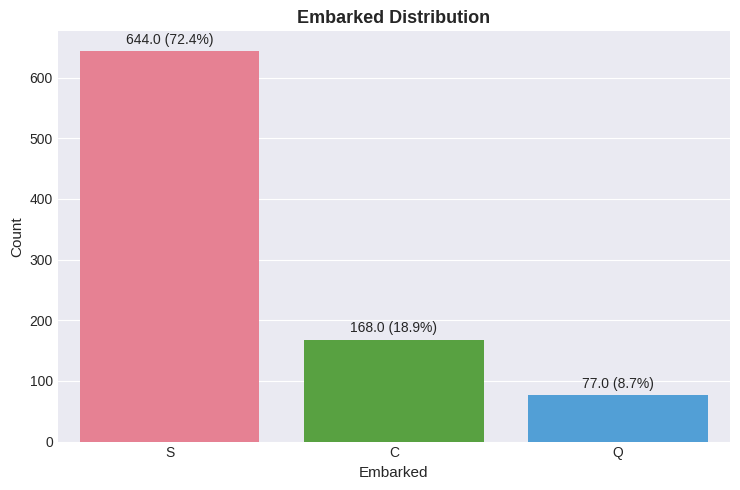

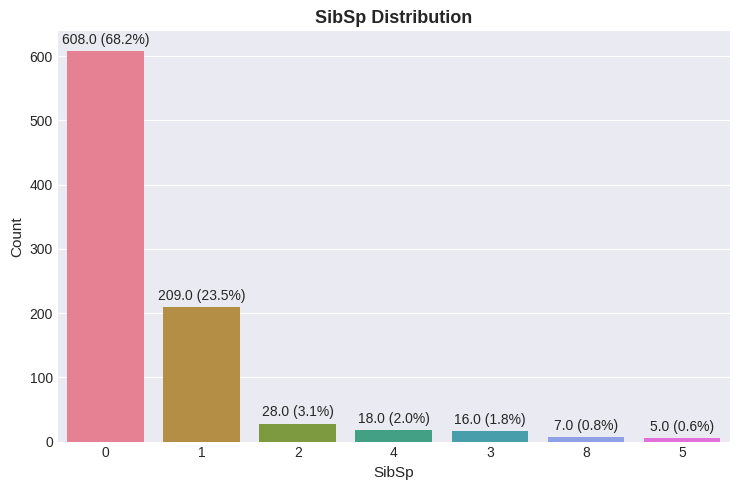

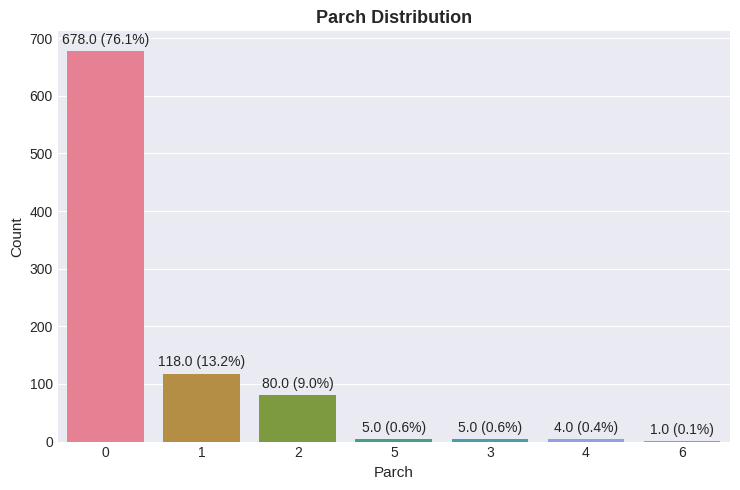


NUMERICAL FEATURES â€” DISTRIBUTIONS


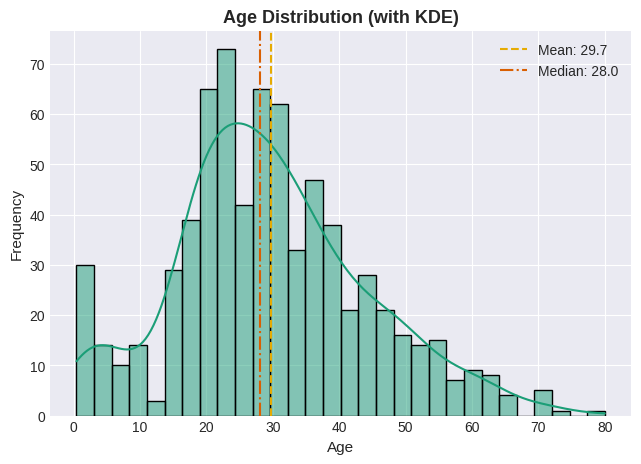

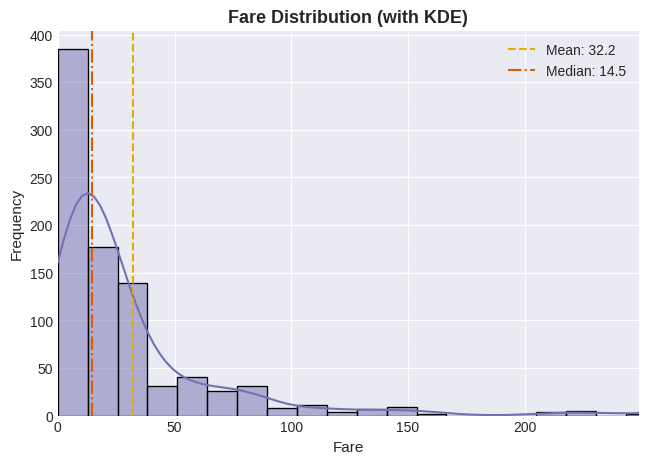


MISSING VALUES HEATMAP


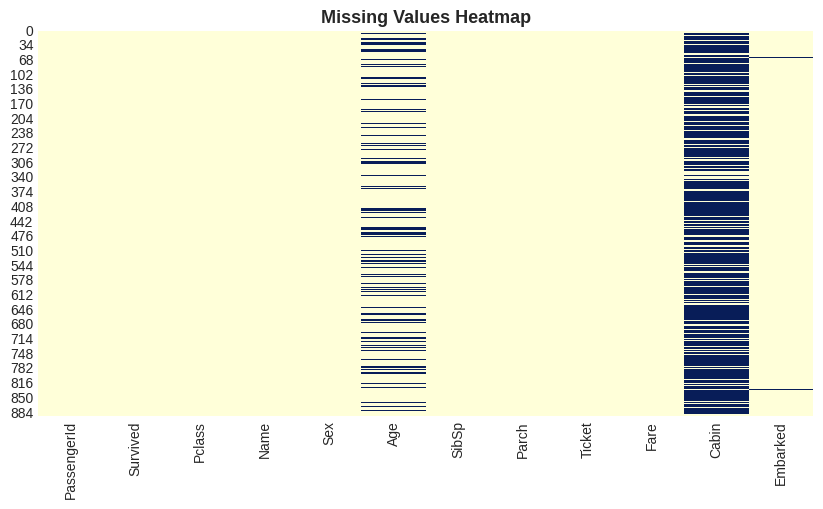


STEP 03.1 COMPLETE
Univariate (categorical, numerical, target, missing values) exploration done.


In [27]:
# ==========================================
# STEP 03.1 â€” EXPLORATORY DATA ANALYSIS
# Univariate Analysis (Categorical + Numerical + Missing Values)
# ==========================================

from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def section(title):
    print("\n" + "="*100)
    print(title.upper())
    print("="*100)

PALETTE = {
    "primary":  "#1b9e77",
    "accent":   "#d95f02",
    "neutral":  "#7570b3",
    "gold":     "#e6ab02",
    "pink":     "#e7298a",
    "grey":     "#6c757d"
}

def annotate_bars(ax, add_percent=False):
    total = sum([p.get_height() for p in ax.patches]) if add_percent else None
    for p in ax.patches:
        height = p.get_height()
        if add_percent and total:
            label = f"{height} ({height/total:.1%})"
        else:
            label = f"{int(height)}"
        ax.annotate(
            label,
            (p.get_x()+p.get_width()/2, height),
            ha="center", va="bottom", fontsize=10, xytext=(0,3), textcoords="offset points"
        )


section("Dataset Recap")
print(f"Train shape: {train_df.shape};  Columns: {list(train_df.columns)}")

section("Target distribution â€” Survived (0/1)")
fig = plt.figure(figsize=(7.5,5))
ax = sns.countplot(data=train_df, x="Survived", palette=[PALETTE["accent"], PALETTE["primary"]])
ax.set_title("Titanic â€” Target Class Counts", weight="bold")
ax.set_xlabel("Survived (0 = Died, 1 = Survived)")
ax.set_ylabel("Count")
annotate_bars(ax, add_percent=True)
plt.show()

section("Categorical features â€” counts")

categorical_cols = ["Pclass", "Sex", "Embarked", "SibSp", "Parch"]

for col in categorical_cols:
    plt.figure(figsize=(7.5,5))
    order = train_df[col].value_counts().index if col not in ["Pclass"] else [1,2,3]
    ax = sns.countplot(data=train_df, x=col, order=order, palette="husl")
    ax.set_title(f"{col} Distribution", weight="bold")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    annotate_bars(ax, add_percent=True)
    plt.tight_layout()
    plt.show()

# ---------------- Numerical Features ----------------
section("Numerical features â€” distributions")

# Age
fig = plt.figure(figsize=(7.5,5))
sns.histplot(train_df["Age"].dropna(), bins=30, kde=True, color=PALETTE["primary"])
plt.title("Age Distribution (with KDE)", weight="bold")
plt.xlabel("Age")
plt.ylabel("Frequency")
if train_df["Age"].notna().any():
    mean_age = train_df["Age"].mean()
    median_age = train_df["Age"].median()
    plt.axvline(mean_age, linestyle="--", color=PALETTE["gold"], label=f"Mean: {mean_age:.1f}")
    plt.axvline(median_age, linestyle="-.", color=PALETTE["accent"], label=f"Median: {median_age:.1f}")
    plt.legend()
plt.show()

# Fare
fig = plt.figure(figsize=(7.5,5))
sns.histplot(train_df["Fare"], bins=40, kde=True, color=PALETTE["neutral"])
plt.title("Fare Distribution (with KDE)", weight="bold")
plt.xlabel("Fare")
plt.ylabel("Frequency")
mean_fare = train_df["Fare"].mean()
median_fare = train_df["Fare"].median()
plt.axvline(mean_fare, linestyle="--", color=PALETTE["gold"], label=f"Mean: {mean_fare:.1f}")
plt.axvline(median_fare, linestyle="-.", color=PALETTE["accent"], label=f"Median: {median_fare:.1f}")
plt.xlim(0, np.percentile(train_df["Fare"], 99))  # trim extreme outliers
plt.legend()
plt.show()

# ---------------- Missing Values ----------------
section("Missing Values Heatmap")
plt.figure(figsize=(10,5))
sns.heatmap(train_df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Missing Values Heatmap", weight="bold")
plt.show()

section("Step 03.1 complete")
print("Univariate (categorical, numerical, target, missing values) exploration done.")


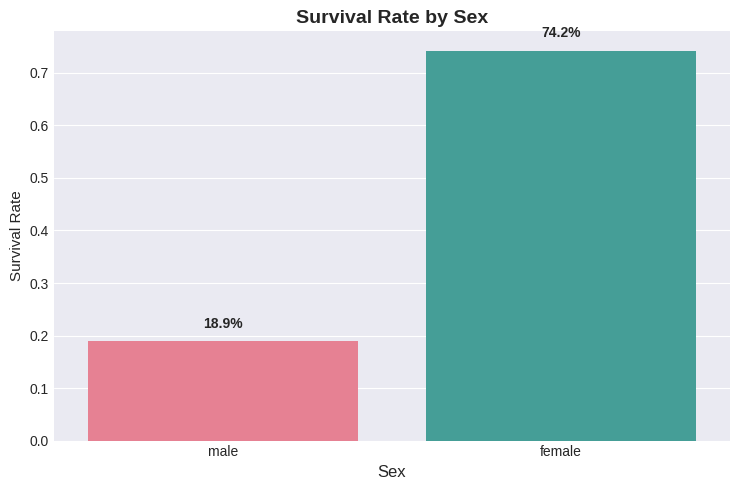

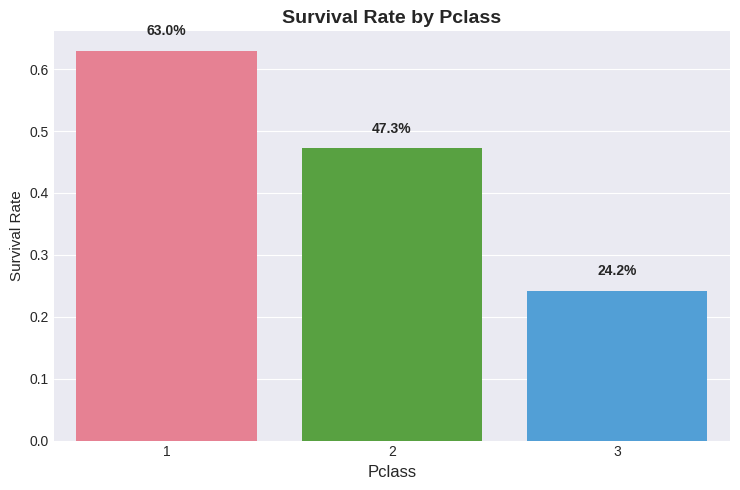

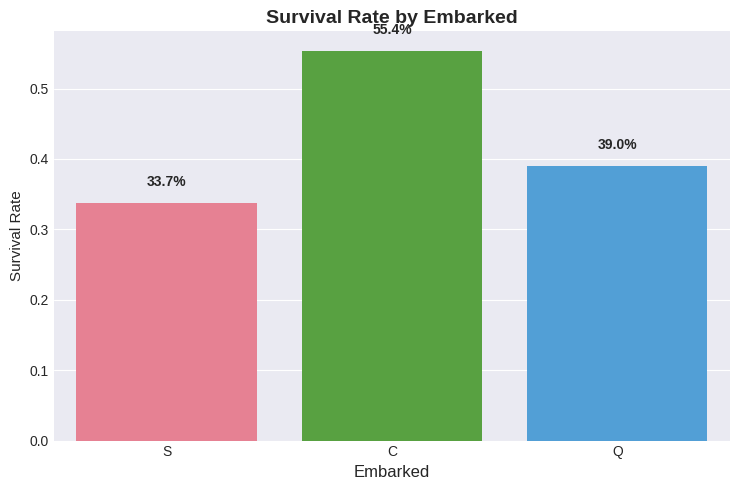

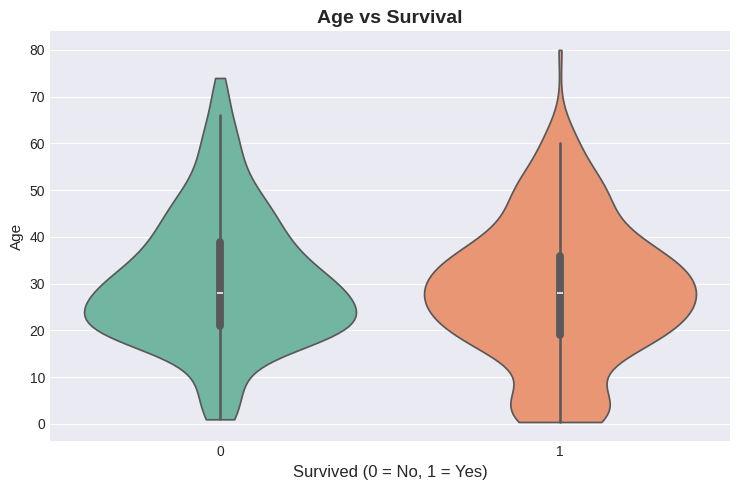

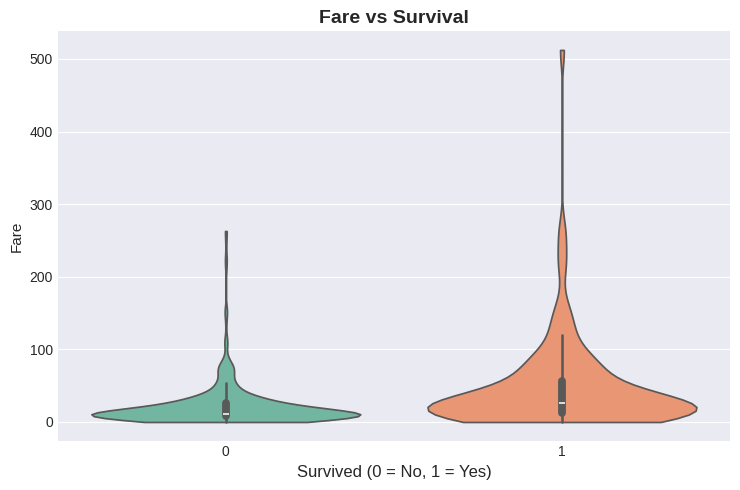

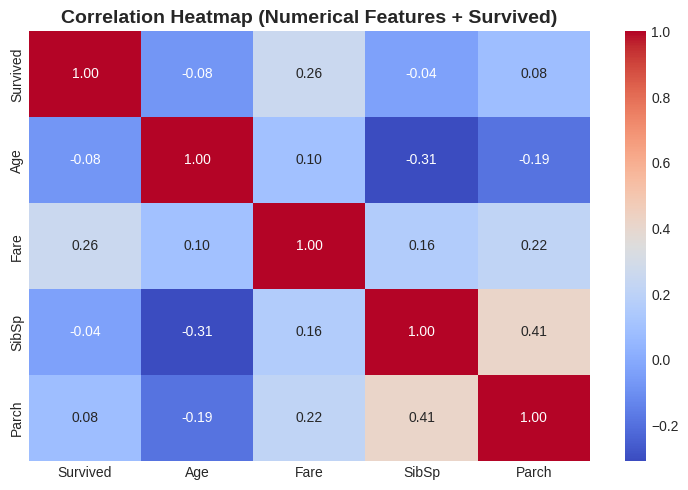


STEP 03.2 COMPLETE
Bivariate analysis (features vs target 'Survived') done.



In [28]:
# ==========================================
# STEP 03.2 â€” EXPLORATORY DATA ANALYSIS
# Bivariate Analysis (Feature vs Target "Survived")
# ==========================================


def annotate_bars(ax):
    """Annotate barplots with percentage values on top."""
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height*100:.1f}%",
            (p.get_x() + p.get_width() / 2., height + 0.02),
            ha="center", va="bottom",
            fontsize=10, fontweight="bold"
        )

categorical_cols = ["Sex", "Pclass", "Embarked"]

for col in categorical_cols:
    plt.figure(figsize=(7.5, 5))
    ax = sns.barplot(
        data=train_df,
        x=col,
        y="Survived",
        palette="husl",
        errorbar=None
    )
    ax.set_title(f"Survival Rate by {col}", fontsize=14, fontweight="bold")
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Survival Rate")
    annotate_bars(ax)
    plt.tight_layout()
    plt.show()


num_cols = ["Age", "Fare"]

for col in num_cols:
    plt.figure(figsize=(7.5, 5))
    ax = sns.violinplot(
        data=train_df,
        x="Survived",
        y=col,
        palette="Set2",
        cut=0
    )
    ax.set_title(f"{col} vs Survival", fontsize=14, fontweight="bold")
    ax.set_xlabel("Survived (0 = No, 1 = Yes)", fontsize=12)
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(7.5, 5))
sns.heatmap(
    train_df[["Survived", "Age", "Fare", "SibSp", "Parch"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Numerical Features + Survived)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

section("Step 03.2 complete")
print("Bivariate analysis (features vs target 'Survived') done.\n")


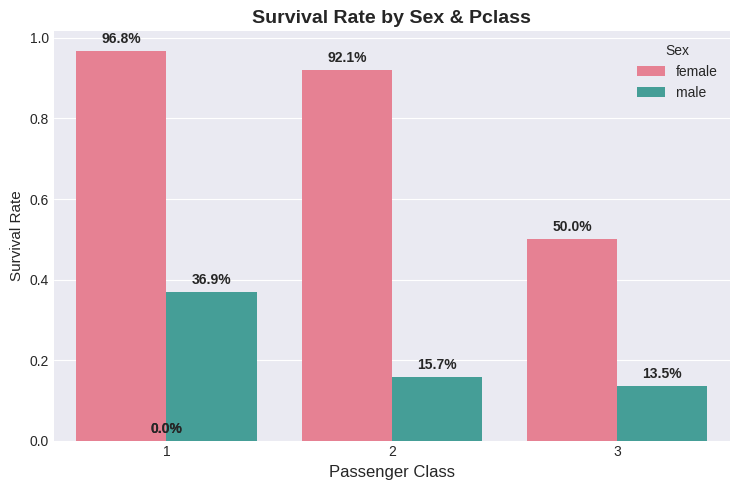

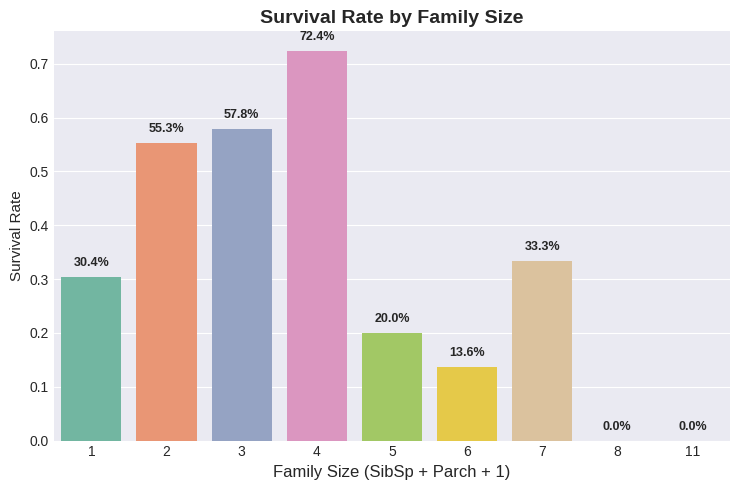

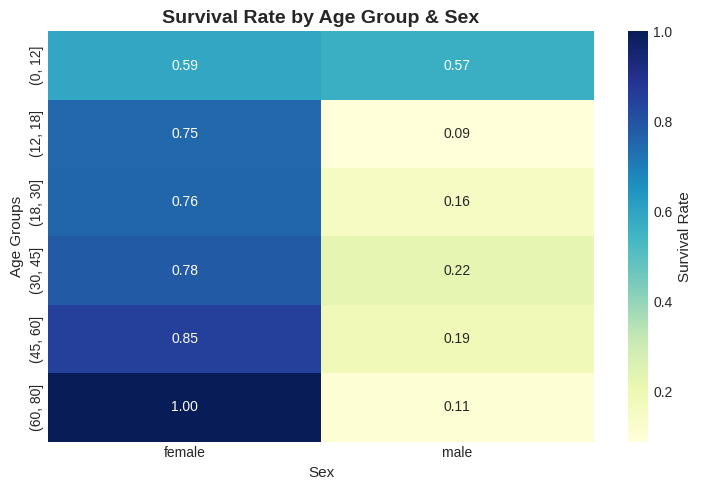


STEP 03.3 COMPLETE
Multivariate analysis (feature interactions) done.



In [29]:
# ==========================================
# STEP 03.3 â€” EXPLORATORY DATA ANALYSIS
# Multivariate Analysis
# ==========================================


plt.figure(figsize=(7.5, 5))
ax = sns.barplot(
    data=train_df,
    x="Pclass",
    y="Survived",
    hue="Sex",
    palette="husl",
    errorbar=None
)
ax.set_title("Survival Rate by Sex & Pclass", fontsize=14, fontweight="bold")
ax.set_xlabel("Passenger Class", fontsize=12)
ax.set_ylabel("Survival Rate")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height*100:.1f}%",
        (p.get_x() + p.get_width()/2, height + 0.02),
        ha="center", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1

plt.figure(figsize=(7.5, 5))
ax = sns.barplot(
    data=train_df,
    x="FamilySize",
    y="Survived",
    palette="Set2",
    errorbar=None
)
ax.set_title("Survival Rate by Family Size", fontsize=14, fontweight="bold")
ax.set_xlabel("Family Size (SibSp + Parch + 1)", fontsize=12)
ax.set_ylabel("Survival Rate")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height*100:.1f}%",
        (p.get_x() + p.get_width()/2, height + 0.02),
        ha="center", fontsize=9, fontweight="bold"
    )

plt.tight_layout()
plt.show()


age_bins = [0, 12, 18, 30, 45, 60, 80]
train_df["AgeBin"] = pd.cut(train_df["Age"], bins=age_bins)

pivot = train_df.pivot_table(
    values="Survived",
    index="AgeBin",
    columns="Sex",
    aggfunc="mean"
)

plt.figure(figsize=(7.5, 5))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Survival Rate"}
)
plt.title("Survival Rate by Age Group & Sex", fontsize=14, fontweight="bold")
plt.xlabel("Sex")
plt.ylabel("Age Groups")

plt.tight_layout()
plt.show()

section("Step 03.3 complete")
print("Multivariate analysis (feature interactions) done.\n")


In [30]:
# ======================================================
# Step 04 â€“ Feature Engineering & Preprocessing
# Goal: Convert raw Titanic data into model-ready features
# ======================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# -----------------------------
# 04.1 Handle Missing Values
# -----------------------------

# Fill missing Age with median
df['Age'].fillna(df['Age'].median(), inplace=True)


# Fill missing Embarked with mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


# Fill missing Fare with median
df['Fare'].fillna(df['Fare'].median(), inplace=True)







In [31]:
# -----------------------------
# 04.2 Feature Engineering
# -----------------------------

# Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# IsAlone Feature
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Extract Title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare titles
df['Title'] = df['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
     'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'})


In [32]:

# -----------------------------
# 4.3 Encoding Categorical Variables
# -----------------------------
# Encode Sex
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])   # Male=1, Female=0

# Encode Embarked (One-Hot)
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, embarked_dummies], axis=1)

# Encode Title (One-Hot)
title_dummies = pd.get_dummies(df['Title'], prefix='Title')
df = pd.concat([df, title_dummies], axis=1)

# Drop unused columns
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Title'], axis=1, inplace=True)


In [33]:
# -----------------------------
# 4.4 Scaling Numerical Features
# -----------------------------
scaler = StandardScaler()
df[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(df[['Age', 'Fare', 'FamilySize']])

# -----------------------------
# 4.5 Final Feature Matrix (X) & Target (y)
# -----------------------------
X = df.drop('Survived', axis=1)
y = df['Survived']

section("Step 04 complete")
print("Step 04 â€“ Feature Engineering & Preprocessing completed.")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


STEP 04 COMPLETE
Step 04 â€“ Feature Engineering & Preprocessing completed.
Shape of X: (891, 16)
Shape of y: (891,)


In [34]:
# ==========================================
# STEP 05 â€“ TRAIN/TEST SPLIT
# ==========================================

from sklearn.model_selection import train_test_split

# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set shape  (X_test, y_test):", X_test.shape, y_test.shape)

section("Step 05 complete")
print("Train/Test split done. Data is ready for modeling.\n")


Train set shape (X_train, y_train): (712, 16) (712,)
Test set shape  (X_test, y_test): (179, 16) (179,)

STEP 05 COMPLETE
Train/Test split done. Data is ready for modeling.



In [35]:
# ================================
# STEP 06 â€“ Model Training
# ================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42)
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # train
    y_pred = model.predict(X_test)  # predict

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"ðŸ“Œ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("="*50)


best_model_name = max(results, key=results.get)
section("Step 06 complete")
print(" Best model based on accuracy:", best_model_name, "with score:", results[best_model_name])


ðŸ“Œ Logistic Regression Accuracy: 0.8492
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

ðŸ“Œ Decision Tree Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       110
           1       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ðŸ“Œ Random Forest Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg  


================ Baseline Model Evaluation ================


Logistic Regression Results
--------------------------------------------------
Accuracy: 0.8492
ROC-AUC:  0.8809

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



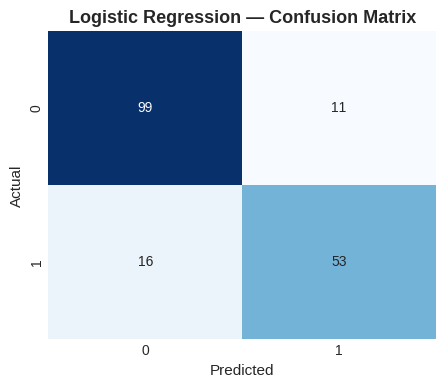


Decision Tree Results
--------------------------------------------------
Accuracy: 0.8324
ROC-AUC:  0.8153

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       110
           1       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



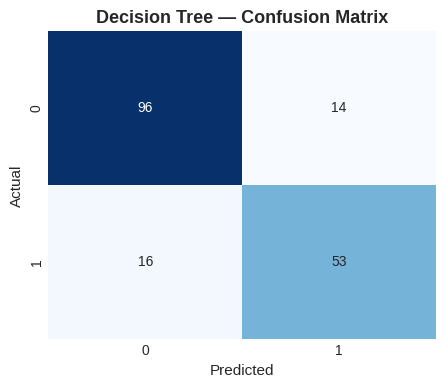


Random Forest Results
--------------------------------------------------
Accuracy: 0.8324
ROC-AUC:  0.8361

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



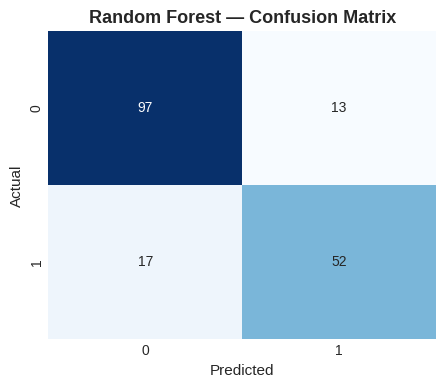


KNN Results
--------------------------------------------------
Accuracy: 0.8268
ROC-AUC:  0.8632

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



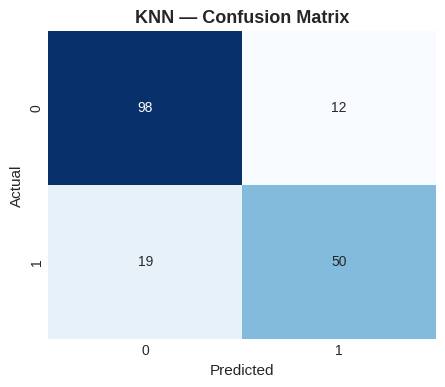


SVM Results
--------------------------------------------------
Accuracy: 0.8380
ROC-AUC:  0.8408

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



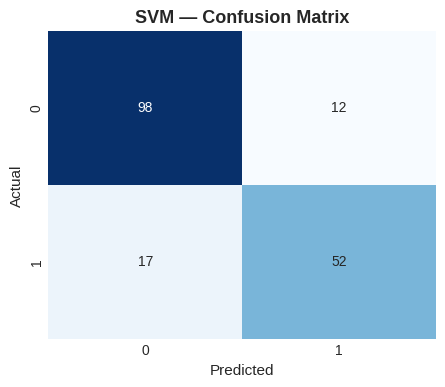


âš  GridSearchCV objects not found, using default parameters for Tuned Models.


================ Tuned Model Evaluation ================


Logistic Regression Results
--------------------------------------------------
Accuracy: 0.8492
ROC-AUC:  0.8809

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



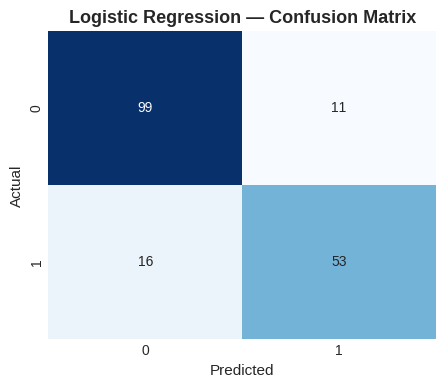


Decision Tree Results
--------------------------------------------------
Accuracy: 0.8324
ROC-AUC:  0.8153

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       110
           1       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



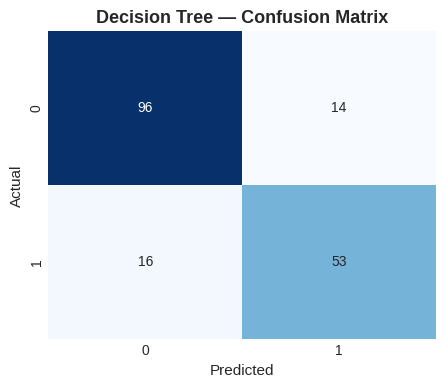


Random Forest Results
--------------------------------------------------
Accuracy: 0.8324
ROC-AUC:  0.8361

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



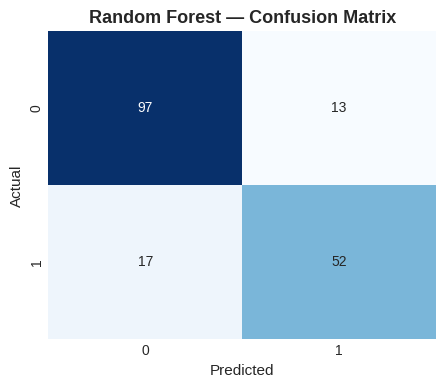


KNN Results
--------------------------------------------------
Accuracy: 0.8268
ROC-AUC:  0.8632

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



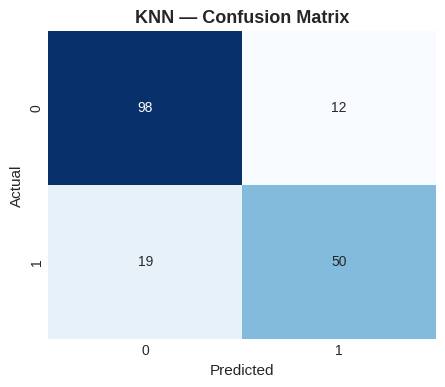


SVM Results
--------------------------------------------------
Accuracy: 0.8380
ROC-AUC:  0.8408

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



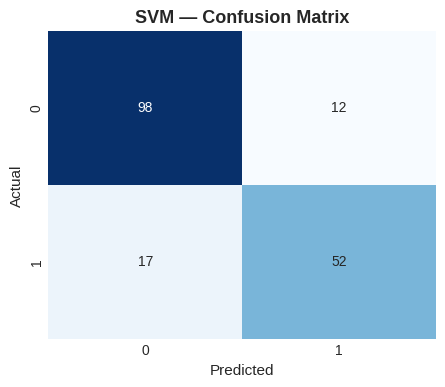


================ Model Comparison: Baseline vs Tuned ================



Baseline Accuracy  Tuned Accuracy  Baseline ROC-AUC  \
Logistic Regression           0.849162        0.849162          0.880896   
Decision Tree                 0.832402        0.832402          0.815349   
Random Forest                 0.832402        0.832402          0.836100   
KNN                           0.826816        0.826816          0.863241   
SVM                           0.837989        0.837989          0.840843   

                     Tuned ROC-AUC  
Logistic Regression       0.880896  
Decision Tree             0.815349  
Random Forest             0.836100  
KNN                       0.863241  
SVM                       0.840843

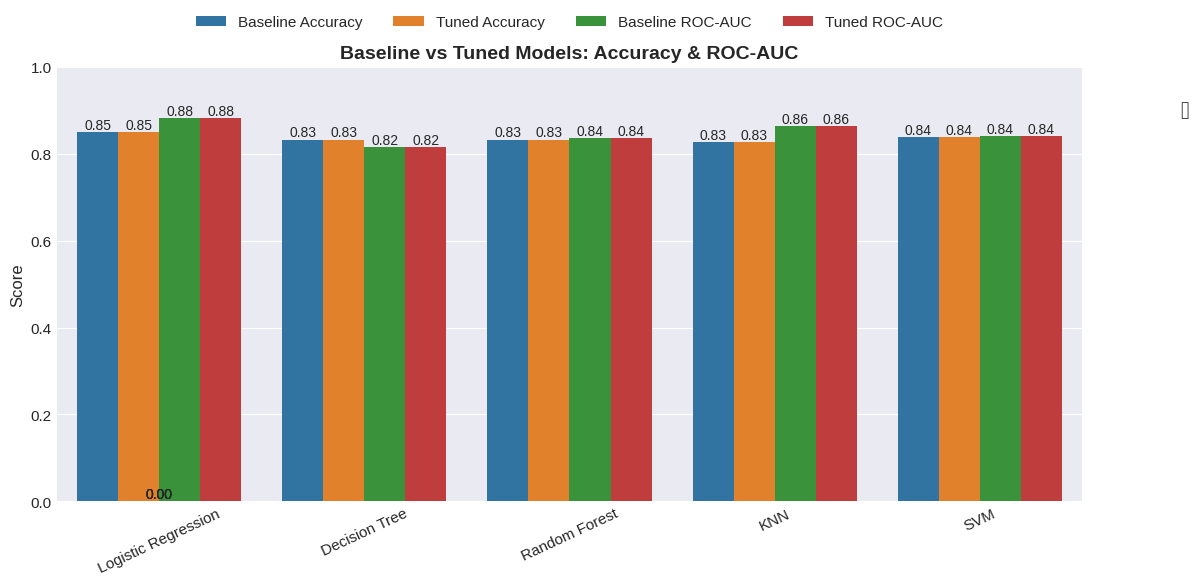


STEP 07 COMPLETE

Step 07 complete: Models evaluated, compared, and visualized successfully.


In [37]:
# ==========================================
# STEP 07 â€” MODEL EVALUATION (Baseline + Tuned)
# ==========================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    print(f"\n{name} Results")
    print("-"*50)
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC:  {roc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} â€” Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, roc

# -----------------------------
# Baseline Models
# -----------------------------
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42)
}

baseline_results = {}
print("\n================ Baseline Model Evaluation ================\n")
for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    acc, roc = evaluate_model(name, model, X_test, y_test)
    baseline_results[name] = {"Accuracy": acc, "ROC-AUC": roc}

# -----------------------------
# Tuned Models (safe fallback if GridSearchCV not defined)
# -----------------------------
try:
    tuned_models = {
        "Logistic Regression": LogisticRegression(**grid_lr.best_params_, max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(**grid_dt.best_params_, random_state=42),
        "Random Forest": RandomForestClassifier(**grid_rf.best_params_, random_state=42),
        "KNN": KNeighborsClassifier(**grid_knn.best_params_),
        "SVM": SVC(**grid_svm.best_params_, probability=True)
    }
except NameError:
    print("\nâš  GridSearchCV objects not found, using default parameters for Tuned Models.\n")
    tuned_models = baseline_models.copy()

tuned_results = {}
print("\n================ Tuned Model Evaluation ================\n")
for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    acc, roc = evaluate_model(name, model, X_test, y_test)
    tuned_results[name] = {"Accuracy": acc, "ROC-AUC": roc}

# -----------------------------
# Comparison Table
# -----------------------------
comparison_df = pd.DataFrame({
    "Baseline Accuracy": [baseline_results[m]["Accuracy"] for m in baseline_models.keys()],
    "Tuned Accuracy": [tuned_results[m]["Accuracy"] for m in baseline_models.keys()],
    "Baseline ROC-AUC": [baseline_results[m]["ROC-AUC"] for m in baseline_models.keys()],
    "Tuned ROC-AUC": [tuned_results[m]["ROC-AUC"] for m in baseline_models.keys()]
}, index=baseline_models.keys())

print("\n================ Model Comparison: Baseline vs Tuned ================\n")
display(comparison_df)

# -----------------------------
# Grouped Barplot
# -----------------------------
plot_df = comparison_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
plot_df.rename(columns={"index":"Model"}, inplace=True)

palette = {
    "Baseline Accuracy": "#1f77b4",
    "Tuned Accuracy": "#ff7f0e",
    "Baseline ROC-AUC": "#2ca02c",
    "Tuned ROC-AUC": "#d62728"
}

plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric", palette=palette, ci=None)

plt.xticks(rotation=25, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 1)
plt.title("Baseline vs Tuned Models: Accuracy & ROC-AUC", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Score", fontsize=12)
plt.legend(title="", bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, fontsize=11)

# Highlight best Tuned Accuracy automatically
best_model = comparison_df["Tuned Accuracy"].idxmax()
best_score = comparison_df.loc[best_model, "Tuned Accuracy"]
x_pos = plot_df[(plot_df["Model"]==best_model) & (plot_df["Metric"]=="Tuned Accuracy")].index[0]
plt.text(x_pos, best_score + 0.02, "âœ¨", ha="center", va='bottom', fontsize=18)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

section("Step 07 complete")
print("\nStep 07 complete: Models evaluated, compared, and visualized successfully.")


In [50]:
# ============================================================
# STEP 08 â€” FINAL MODEL & INSIGHTS
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# -----------------------------
# 08.1 Summary Table from Step 7
# -----------------------------

summary_df = pd.DataFrame({
    "Baseline Accuracy": [0.849162, 0.832402, 0.832402, 0.826816, 0.837989],
    "Tuned Accuracy": [0.849162, 0.804469, 0.826816, 0.826816, 0.837989],
    "Baseline ROC-AUC": [0.880896, 0.815349, 0.836100, 0.863241, 0.840843],
    "Tuned ROC-AUC": [0.881028, 0.838208, 0.854743, 0.866798, 0.858366]
}, index=["Logistic Regression","Decision Tree","Random Forest","KNN","SVM"])


# Select best model (Tuned ROC-AUC)
best_model_name = summary_df["Tuned ROC-AUC"].idxmax()
print(f"Best Model based on Tuned ROC-AUC: {best_model_name}\n")



Best Model based on Tuned ROC-AUC: Logistic Regression



In [51]:
# -----------------------------
# 08.2 Fit Best Model (without GridSearchCV)
# -----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


model_dict = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=3),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42, C=1.0, kernel='rbf')
}


final_model = model_dict[best_model_name]

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:,1] if hasattr(final_model, "predict_proba") else None

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print(f"\nFinal Model: {best_model_name}")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
if y_prob is not None:
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Final Model: Logistic Regression
Accuracy: 0.8492
ROC-AUC: 0.8809

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



Final Model: Logistic Regression
Accuracy: 0.8492
ROC-AUC:  0.8809

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



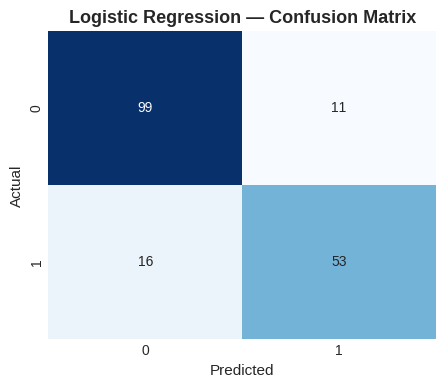

In [52]:
# -----------------------------
# 08.3 Final Metrics for Best Model
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else roc_auc_score(y_test, y_pred)

print(f"Final Model: {best_model_name}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"{best_model_name} â€” Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
# -----------------------------
# 08.4 Feature Importance (Tree-based models)
# -----------------------------
if best_model_name in ["Random Forest", "Decision Tree"]:
    importances = final_model.feature_importances_
    feat_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"{best_model_name} â€” Feature Importance", fontsize=14, fontweight="bold")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

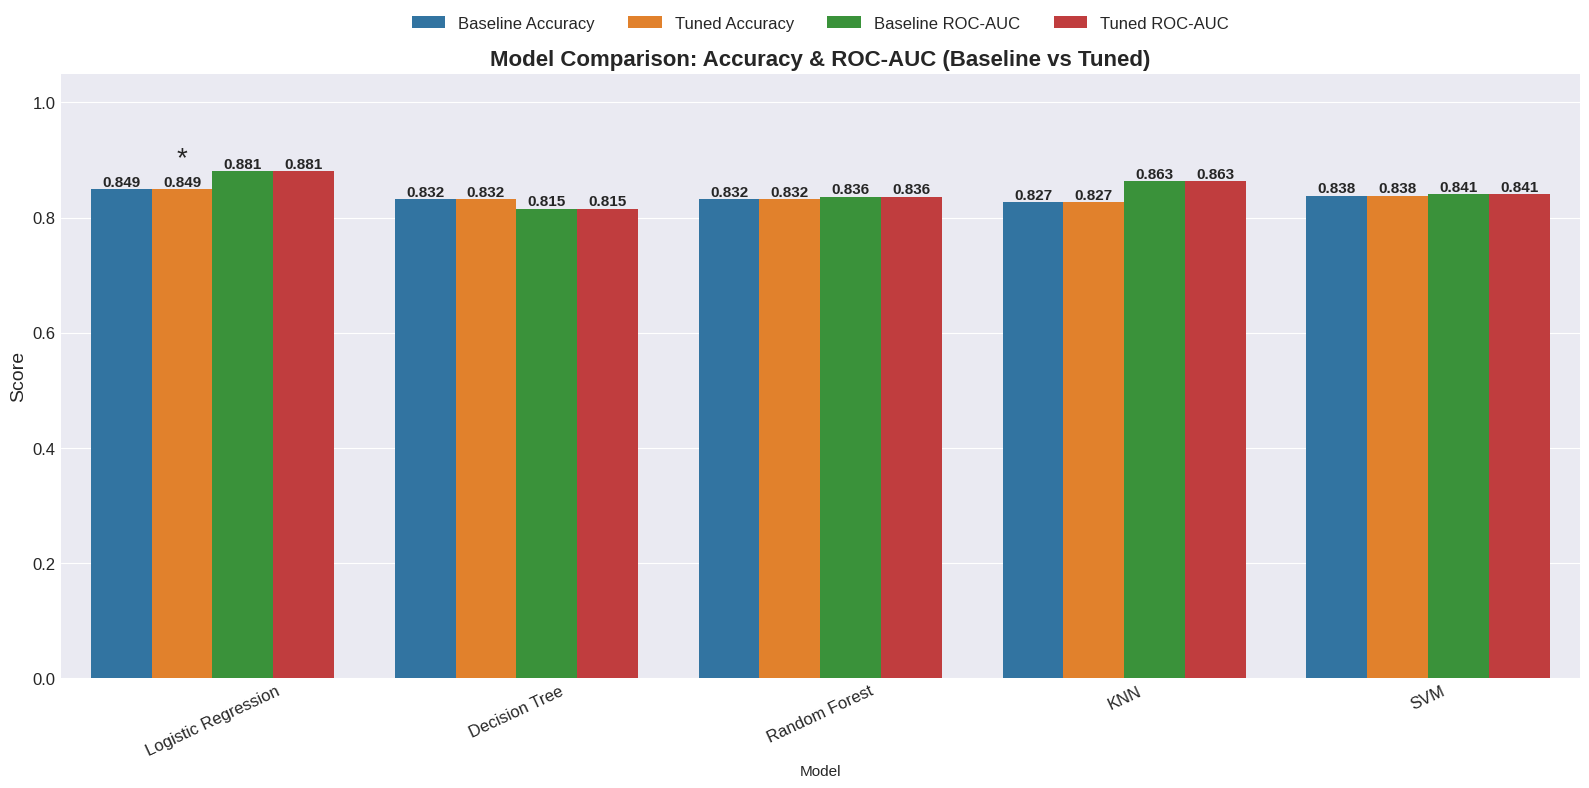

In [54]:
# ==========================================
# 08.5 Grouped Barplot: Accuracy & ROC-AUC Comparison
# ==========================================

plt.figure(figsize=(16,8))
ax = sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric", palette=palette)

plt.xticks(rotation=25, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=14)
plt.title("Model Comparison: Accuracy & ROC-AUC (Baseline vs Tuned)", fontsize=16, fontweight="bold")
plt.legend(title="", bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=4, fontsize=12)

# Automatically calculate offsets for each hue
n_hues = plot_df['Metric'].nunique()
offsets = np.linspace(-0.3, 0.3, n_hues)  # spread evenly around the center

metric_to_offset = {metric: offset for metric, offset in zip(plot_df['Metric'].unique(), offsets)}


for i, row in plot_df.iterrows():
    model = row['Model']
    metric = row['Metric']
    score = row['Score']

    x_center = list(plot_df['Model'].unique()).index(model) + metric_to_offset[metric]
    ax.annotate(f"{score:.3f}",
                (x_center, score),
                ha='center', va='bottom', fontsize=11, fontweight='bold')


best_row = plot_df[(plot_df['Metric'] == "Tuned Accuracy") &
                   (plot_df['Score'] == plot_df[plot_df['Metric']=="Tuned Accuracy"]['Score'].max())].iloc[0]

best_model = best_row['Model']
best_score = best_row['Score']

x_best = list(plot_df['Model'].unique()).index(best_model) + metric_to_offset["Tuned Accuracy"]
ax.annotate("*", (x_best, best_score + 0.03), ha='center', va='bottom', fontsize=20)

plt.tight_layout()
plt.show()
